# Introduction

This project aims to classify 25 of the top imaged birds in this kaggle dataset (https://www.kaggle.com/datasets/gpiosenka/100-bird-species) using deep learning. To do this, images will be given to a deep learning model to train the model, the model will try to predict new images in a test data set, and the accuracy for each bird will be calculated. 

Deep learning can be used for many applications such as image classification, natural language processing, text to image, etc. Deep learning uses neural networks and weights that connect these neural networks to predict new data. 

In this notebook, 3 deep learning models will be compared when classifying the top 25 imaged birds. One model will be basic, the second model will include some augmentation, and the third model will include augmentation and a pre-trained model.

In [251]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import os
from glob import glob 
from sklearn.metrics import confusion_matrix, classification_report


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [252]:
# List all directories.
print(os.listdir('/Users/matthew_1/Documents/other/deep_learning_proj/archive'))

# Save the training, valid, and testing directories.
train = '/Users/matthew_1/Documents/other/deep_learning_proj/archive/train'
valid = '/Users/matthew_1/Documents/other/deep_learning_proj/archive/valid'
test = '/Users/matthew_1/Documents/other/deep_learning_proj/archive/test'

# Print 20 bird names and the jpgs for DALMATIAN PELICAN.
print(os.listdir(train)[:20])
print(os.listdir(train + '/DALMATIAN PELICAN'))

['valid', 'birds.csv', '.DS_Store', 'EfficientNetB0-525-(224 X 224)- 98.97.h5', 'test', 'train']
['CREAM COLORED WOODPECKER', 'CAMPO FLICKER', 'RUFUOS MOTMOT', 'WHITE TAILED TROPIC', 'KOOKABURRA', 'TREE SWALLOW', 'ORNATE HAWK EAGLE', 'AMERICAN REDSTART', 'EASTERN TOWEE', 'IBERIAN MAGPIE', 'HOOPOES', 'PHAINOPEPLA', 'BELTED KINGFISHER', 'CRESTED CARACARA', 'IMPERIAL SHAQ', 'VIOLET GREEN SWALLOW', 'CAPE MAY WARBLER', 'EASTERN MEADOWLARK', 'EUROPEAN GOLDFINCH', 'HOATZIN']
['016.jpg', '002.jpg', '003.jpg', '017.jpg', '149.jpg', '029.jpg', '001.jpg', '015.jpg', '014.jpg', '028.jpg', '148.jpg', '158.jpg', '004.jpg', '010.jpg', '038.jpg', '039.jpg', '011.jpg', '005.jpg', '159.jpg', '013.jpg', '007.jpg', '006.jpg', '012.jpg', '129.jpg', '101.jpg', '115.jpg', '049.jpg', '075.jpg', '061.jpg', '060.jpg', '074.jpg', '048.jpg', '114.jpg', '100.jpg', '128.jpg', '116.jpg', '102.jpg', '089.jpg', '062.jpg', '076.jpg', '077.jpg', '063.jpg', '088.jpg', '103.jpg', '117.jpg', '113.jpg', '107.jpg', '098.jpg'

The data consists of a valid, test, and trian directory, a birds.csv that has information about each image, and an EfficientNetB0 model which is a pre-trained model. 

In [280]:
# Read in the csv file.
dataset = pd.read_csv('/Users/matthew_1/Documents/other/deep_learning_proj/archive/birds.csv')
print(dataset.head())

# Get just the training data and subset for filepaths and labels. 
train_df = dataset[dataset['data set'] == 'train']
train_df = train_df[['filepaths', 'labels']]
print(train_df.head())

# Add the full path to 'filepaths'.
train_df['filepaths'] = train_df['filepaths'].apply(lambda x: os.path.join('/Users/matthew_1/Documents/other/deep_learning_proj/archive/', x))
print(train_df.head())
print(len(train_df))

   class id                      filepaths           labels data set  \
0       0.0  train/ABBOTTS BABBLER/001.jpg  ABBOTTS BABBLER    train   
1       0.0  train/ABBOTTS BABBLER/007.jpg  ABBOTTS BABBLER    train   
2       0.0  train/ABBOTTS BABBLER/008.jpg  ABBOTTS BABBLER    train   
3       0.0  train/ABBOTTS BABBLER/009.jpg  ABBOTTS BABBLER    train   
4       0.0  train/ABBOTTS BABBLER/002.jpg  ABBOTTS BABBLER    train   

        scientific name  
0  MALACOCINCLA ABBOTTI  
1  MALACOCINCLA ABBOTTI  
2  MALACOCINCLA ABBOTTI  
3  MALACOCINCLA ABBOTTI  
4  MALACOCINCLA ABBOTTI  
                       filepaths           labels
0  train/ABBOTTS BABBLER/001.jpg  ABBOTTS BABBLER
1  train/ABBOTTS BABBLER/007.jpg  ABBOTTS BABBLER
2  train/ABBOTTS BABBLER/008.jpg  ABBOTTS BABBLER
3  train/ABBOTTS BABBLER/009.jpg  ABBOTTS BABBLER
4  train/ABBOTTS BABBLER/002.jpg  ABBOTTS BABBLER
                                           filepaths           labels
0  /Users/matthew_1/Documents/other/deep_

The birds.csv contains a class id, filepaths to each image, labels of each image, which dataset it comes from (train, test, or valid) and the scientific name of the bird. I changed the filespath name to include the full path so that there are no issues getting the images. 

In [285]:
# Get the first image of the training data. 
train_df['filepaths'][0]

# Open the image file.
img = Image.open(train_df['filepaths'][0])

# Get the image size.
print(img.size)


(224, 224)


Each image has 224 pixels for the height and 224 pixels for the width. Also, looking at the kaggle page each image is RGB, so the image info is (224, 224, 3).

/var/folders/bt/x91p051x16x2_cxt08b3qty80000gp/T/ipykernel_82374/3191165622.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='viridis')


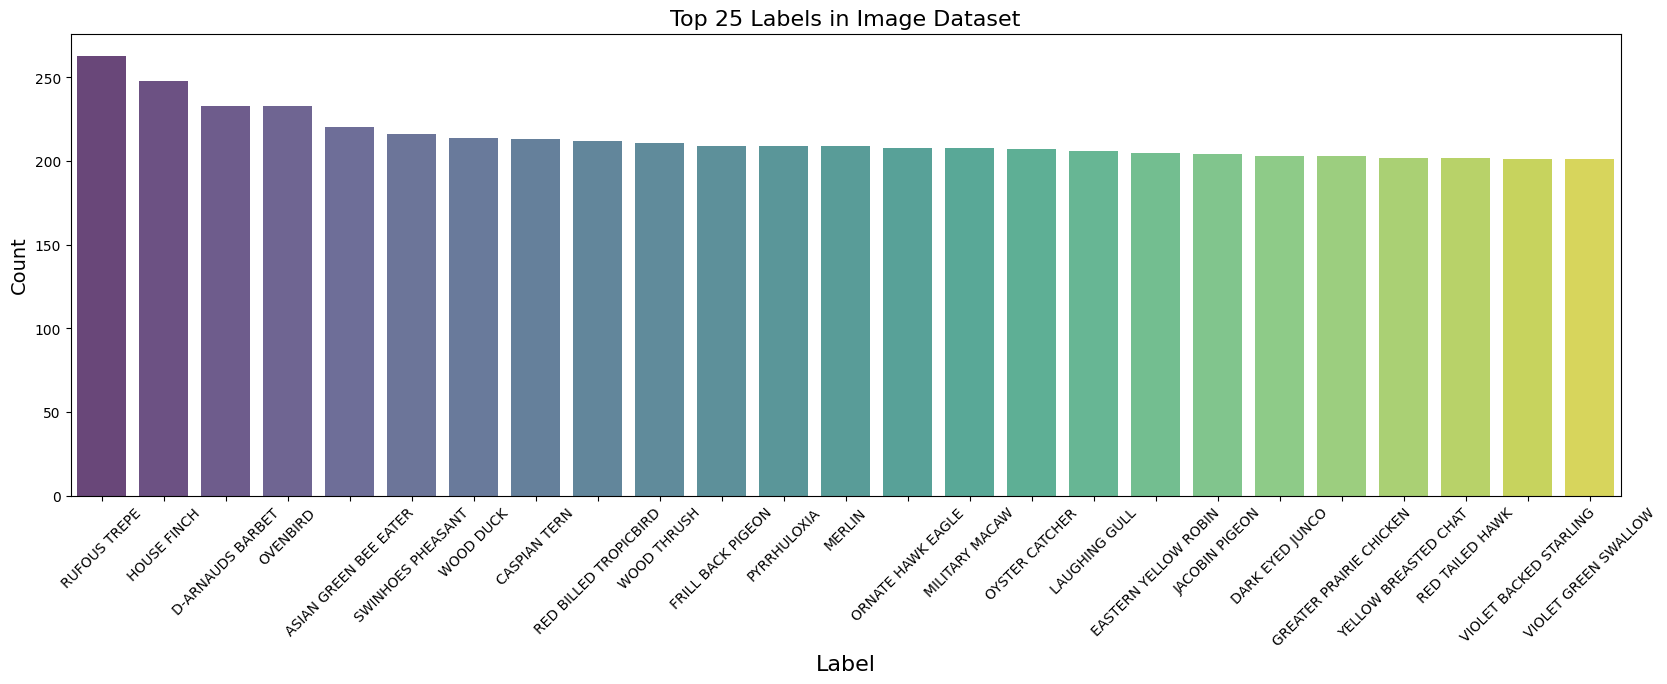

In [254]:
# Get the top 25 labels.
label_counts = train_df['labels'].value_counts()[:25]

# Plot the top 25 pictured birds. 
plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='viridis')
plt.title('Top 25 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=16)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

These top 25 imaged birds are all above 200 images with the highest bird imaged being the Rufous Trepe. 

In [286]:
# Save a list of the top 25 pictured birds. 
top_birds = train_df['labels'].value_counts()[:25].index[:25]

# Filter the DataFrame to only include rows with labels that are in the top 25.
top_birds_train_df = train_df[train_df['labels'].isin(top_birds)]

# Add the full path to 'filepaths'.
top_birds_train_df.loc[:, 'filepaths'] = top_birds_train_df['filepaths'].apply(lambda x: os.path.join('/Users/matthew_1/Documents/other/deep_learning_proj/archive', x))
print(top_birds_train_df.head())
print(len(top_birds_train_df))

                                              filepaths                 labels
6255  /Users/matthew_1/Documents/other/deep_learning...  ASIAN GREEN BEE EATER
6256  /Users/matthew_1/Documents/other/deep_learning...  ASIAN GREEN BEE EATER
6257  /Users/matthew_1/Documents/other/deep_learning...  ASIAN GREEN BEE EATER
6258  /Users/matthew_1/Documents/other/deep_learning...  ASIAN GREEN BEE EATER
6259  /Users/matthew_1/Documents/other/deep_learning...  ASIAN GREEN BEE EATER
5340


Since I want only the top 25 birds, I subset the data to those top 25. In the training, there are 5,340 images which the model will be trained on. 

In [292]:
# Check for duplicates. 
duplicates = top_birds_train_df.duplicated()
print("Number of duplicate rows: ", duplicates.sum())

# Print the counts of each bird.
bird_counts = top_birds_train_df['labels'].value_counts()
print(bird_counts)

Number of duplicate rows:  0
labels
RUFOUS TREPE               263
HOUSE FINCH                248
OVENBIRD                   233
D-ARNAUDS BARBET           233
ASIAN GREEN BEE EATER      220
SWINHOES PHEASANT          216
WOOD DUCK                  214
CASPIAN TERN               213
RED BILLED TROPICBIRD      212
WOOD THRUSH                211
FRILL BACK PIGEON          209
MERLIN                     209
PYRRHULOXIA                209
ORNATE HAWK EAGLE          208
MILITARY MACAW             208
OYSTER CATCHER             207
LAUGHING GULL              206
EASTERN YELLOW ROBIN       205
JACOBIN PIGEON             204
GREATER PRAIRIE CHICKEN    203
DARK EYED JUNCO            203
RED TAILED HAWK            202
YELLOW BREASTED CHAT       202
VIOLET BACKED STARLING     201
VIOLET GREEN SWALLOW       201
Name: count, dtype: int64


There are no duplicated pictures based on the picture name. Each bird from the top 25 imaged birds has over 200 pictures with the least being 201 (VIOLET GREEN SWALLOW and VIOLET BACKED STARLING) and the most being 263 (RUFOUS TREPE).

In [256]:
# From the csv, save rows for the test dataset. 
test_df = dataset[dataset['data set'] == 'test']
test_df = test_df[['filepaths', 'labels']]

# Add the full path to 'filepaths'.
test_df['filepaths'] = test_df['filepaths'].apply(lambda x: os.path.join('/Users/matthew_1/Documents/other/deep_learning_proj/archive/', x))
top_birds_test_df = test_df[test_df['labels'].isin(top_birds)]
print(top_birds_test_df.head())
print(len(top_birds_test_df))

# From the csv, save rows for the validation dataset. 
val_df = dataset[dataset['data set'] == 'valid']
val_df = val_df[['filepaths', 'labels']]

# Add the full path to 'filepaths'.
val_df['filepaths'] = val_df['filepaths'].apply(lambda x: os.path.join('/Users/matthew_1/Documents/other/deep_learning_proj/archive/', x))
top_birds_val_df = val_df[val_df['labels'].isin(top_birds)]
print(top_birds_val_df.head())
print(len(top_birds_val_df))


                                               filepaths  \
84835  /Users/matthew_1/Documents/other/deep_learning...   
84836  /Users/matthew_1/Documents/other/deep_learning...   
84837  /Users/matthew_1/Documents/other/deep_learning...   
84838  /Users/matthew_1/Documents/other/deep_learning...   
84839  /Users/matthew_1/Documents/other/deep_learning...   

                      labels  
84835  ASIAN GREEN BEE EATER  
84836  ASIAN GREEN BEE EATER  
84837  ASIAN GREEN BEE EATER  
84838  ASIAN GREEN BEE EATER  
84839  ASIAN GREEN BEE EATER  
125
                                               filepaths  \
87460  /Users/matthew_1/Documents/other/deep_learning...   
87461  /Users/matthew_1/Documents/other/deep_learning...   
87462  /Users/matthew_1/Documents/other/deep_learning...   
87463  /Users/matthew_1/Documents/other/deep_learning...   
87464  /Users/matthew_1/Documents/other/deep_learning...   

                      labels  
87460  ASIAN GREEN BEE EATER  
87461  ASIAN GREEN BEE EAT

Doing the same thing for the validation and testing datasets, there are 125 images for validaiton and 125 images for testing. For the test and validation datasets, each bird has 5 images. 

                                               filepaths  \
6255   /Users/matthew_1/Documents/other/deep_learning...   
20717  /Users/matthew_1/Documents/other/deep_learning...   
28711  /Users/matthew_1/Documents/other/deep_learning...   
29239  /Users/matthew_1/Documents/other/deep_learning...   
31913  /Users/matthew_1/Documents/other/deep_learning...   

                      labels  
6255   ASIAN GREEN BEE EATER  
20717           CASPIAN TERN  
28711       D-ARNAUDS BARBET  
29239        DARK EYED JUNCO  
31913   EASTERN YELLOW ROBIN  


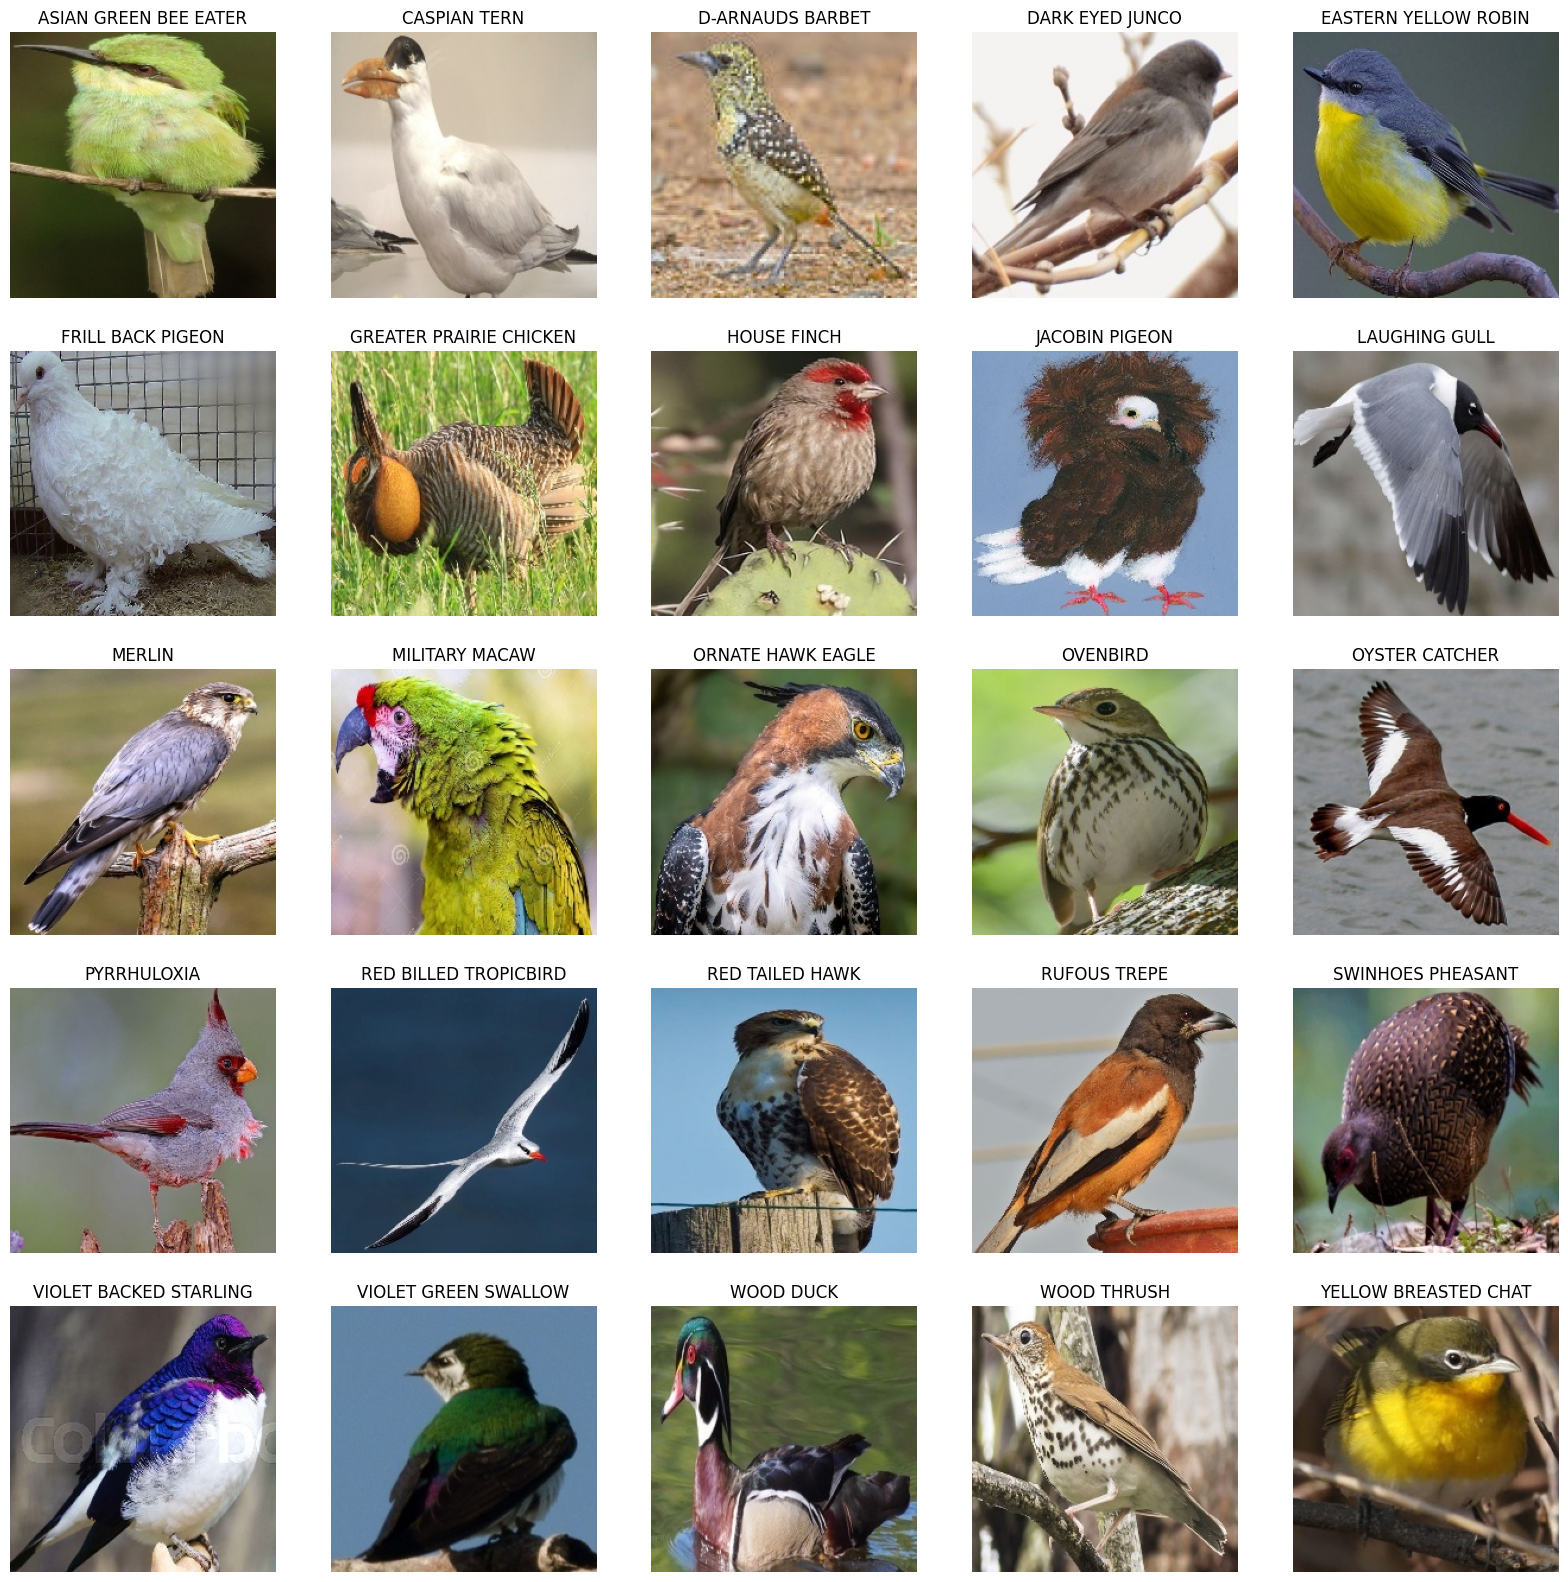

In [287]:
# Get one filepath for each bird.
unique_birds_df = top_birds_train_df.drop_duplicates(subset='labels')
print(unique_birds_df.head())

# Plot one photo of each bird. Do this for all 25 birds. 
fig, axs = plt.subplots(5, 5, figsize=(20, 20))

for i, (index, row) in enumerate(unique_birds_df.iterrows()):
    img = Image.open(os.path.join(row['filepaths']))
    row_idx = i // 5  # Integer division gives the row index
    col_idx = i % 5   # Modulo operation gives the column index
    axs[row_idx, col_idx].imshow(img)
    axs[row_idx, col_idx].axis('off')
    axs[row_idx, col_idx].set_title(row['labels'])

plt.show()

# Model 1

For each model, I will flatten the data, put it through a dense layer, batch normalize it to reduce overfitting, and then output the classes. I also resized the images from 224 to 155 so that the models run faster.

**Flatten** - Reshapes the tensor so that there is only one dimension. 

**Dense** - A fully connected layer. Each node of the input will connect to each node in this layer. 

**Batch Normalization** - Normalizes the data. This can help with overtraining.

**Optimization** - Adaptive Moment Estimation (Adam) optimizer is a stochastic gradient descent that scales the learning rate. 

**Overtraining** - Early stopping and reduced learning. Earling stopping will keep track of the validation loss and stop early if it starts to rise after a certain number of epochs. Reduced learning will reduce the learning rate when the model stops improving. 

In [258]:
# Initialize batch size, image height, and image width.
batch_size = 32
img_h = 155
img_w = 155

In [259]:
# Create data generators for our first model.
train_datagen = ImageDataGenerator(rescale=1./255)

# Create the training generator. 
train_generator = train_datagen.flow_from_dataframe(
    top_birds_train_df,
    x_col= 'filepaths', 
    y_col= 'labels',
    target_size=(img_h, img_w), 
    batch_size=batch_size,
    class_mode='categorical',
    seed=12345,
    shuffle= True)

# Create the validation generator. 
val_generator = train_datagen.flow_from_dataframe(
    top_birds_val_df,
    x_col= 'filepaths', 
    y_col= 'labels',
    target_size=(img_h, img_w), 
    batch_size=batch_size,
    class_mode='categorical',
    seed=12345,
    shuffle= True)

# Create the testing generator. 
test_generator = train_datagen.flow_from_dataframe(
    top_birds_test_df,
    x_col= 'filepaths', 
    y_col= None,
    target_size=(img_h, img_w), 
    batch_size=batch_size,
    class_mode=None,
    seed=12345,
    shuffle= False)

Found 5340 validated image filenames belonging to 25 classes.
Found 125 validated image filenames belonging to 25 classes.
Found 125 validated image filenames.


In [260]:
# Define the model 1. 
model_1 = Sequential([
    Input(shape=(img_h, img_w, 3)),
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(25, activation='softmax')
])

# Get a summary of the model. 
model_1.summary()

# Compile the model. 
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'recall', 'f1_score', 'auc'])

Model: "sequential_54"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_20 (Flatten)            │ (None, 72075)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 512)            │    36,902,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 25)             │        12,825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,917,785 (140.83 MB)

 Trainable params: 36,916,761 (140.83 MB)

 Non-trainable params: 1,024 (4.00 KB)

There are 36,916,761 parameters which are trainable. 

In [261]:
# Define early stopping and reduced learning. 
early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1, restore_best_weights = True)
reduce_learning = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1, min_lr=1e-6)

# Train the model.
history_1 = model_1.fit(
    train_generator,
    validation_data=val_generator, 
    epochs=30, 
    verbose=1,
    callbacks=[reduce_learning, early_stopping])

Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


167/167 ━━━━━━━━━━━━━━━━━━━━ 18s 98ms/step - accuracy: 0.1738 - auc: 0.7118 - f1_score: 0.1484 - loss: 2.9671 - recall: 0.0160 - val_accuracy: 0.1840 - val_auc: 0.6888 - val_f1_score: 0.1643 - val_loss: 3.4810 - val_recall: 0.0240 - learning_rate: 0.0010
Epoch 2/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.4058 - auc: 0.8731 - f1_score: 0.3901 - loss: 2.1819 - recall: 0.0821 - val_accuracy: 0.1600 - val_auc: 0.7041 - val_f1_score: 0.1332 - val_loss: 3.4229 - val_recall: 0.0720 - learning_rate: 0.0010
Epoch 3/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - accuracy: 0.4775 - auc: 0.9047 - f1_score: 0.4698 - loss: 1.9748 - recall: 0.1080 - val_accuracy: 0.1360 - val_auc: 0.6944 - val_f1_score: 0.0744 - val_loss: 3.7725 - val_recall: 0.0880 - learning_rate: 0.0010
Epoch 4/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - accuracy: 0.5120 - auc: 0.9179 - f1_score: 0.4991 - loss: 1.8627 - recall: 0.1351 - val_accuracy: 0.1440 - val_auc: 0.6670 - val_f1_score: 0.0912 - val_loss:

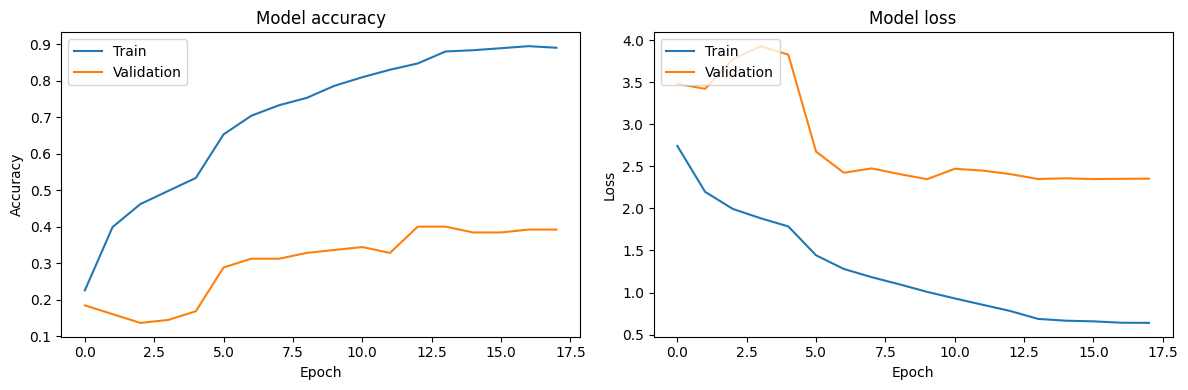

In [262]:
# Plot training & validation accuracy values.
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values.
plt.subplot(1, 2, 2)
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

The training data has good accuracy and loss over the epochs but the validation dataset isn't the best. Ideally the validation line will be just below the training line if the model is fit well but it looks like the model is underfitting. 

In [263]:
# Predict on the test data.
predictions = model_1.predict(test_generator)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


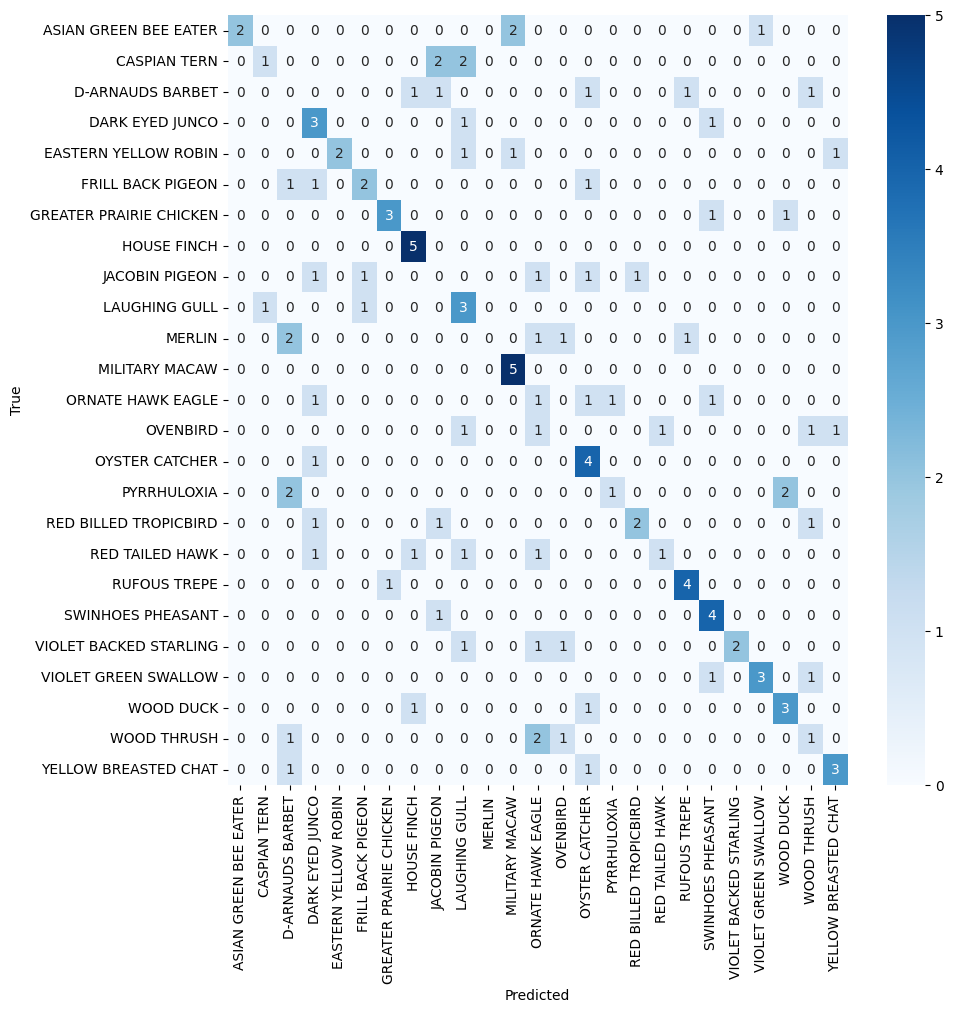

                         precision    recall  f1-score   support

  ASIAN GREEN BEE EATER       1.00      0.40      0.57         5
           CASPIAN TERN       0.50      0.20      0.29         5
       D-ARNAUDS BARBET       0.00      0.00      0.00         5
        DARK EYED JUNCO       0.33      0.60      0.43         5
   EASTERN YELLOW ROBIN       1.00      0.40      0.57         5
      FRILL BACK PIGEON       0.50      0.40      0.44         5
GREATER PRAIRIE CHICKEN       0.75      0.60      0.67         5
            HOUSE FINCH       0.62      1.00      0.77         5
         JACOBIN PIGEON       0.00      0.00      0.00         5
          LAUGHING GULL       0.30      0.60      0.40         5
                 MERLIN       0.00      0.00      0.00         5
         MILITARY MACAW       0.62      1.00      0.77         5
      ORNATE HAWK EAGLE       0.12      0.20      0.15         5
               OVENBIRD       0.00      0.00      0.00         5
         OYSTER CATCHER 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [264]:
# Get the actual test labels.
true_labels = top_birds_test_df['labels'].values

# Get the indices of the max probabilities.
predicted_classes = np.argmax(predictions, axis=1)

# Get a dictionary mapping indices to class names.
index_to_class = {v: k for k, v in train_generator.class_indices.items()}

# Get the class names.
predicted_birds = [index_to_class[i] for i in predicted_classes]

# Get the unique class labels from the true and predicted labels.
class_labels = np.unique(np.concatenate((true_labels, predicted_birds)))

# Compute confusion matrix with those class labels. 
cm = confusion_matrix(true_labels, predicted_birds, labels=class_labels)

# Plot the confusion matrix.
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot the precision, recall, and f1-score for all 25 birds and the overall accuracy. 
print(classification_report(top_birds_test_df.labels, predicted_birds))

The first model has an accuracy of 44%. Some birds are predicted better than others. For example, the HOUSE FINCH has okay precision but perfect recall. The weighted precision is 48%, recall is 44%, and f1-score is 42%. 

# Model 2 - Data augmentation 

For the second model, the images will go through some augmentation. This includes rotation, shifting, shearing, zooming, and flipping. Usually data augmentation will produce better perfoming models. 

In [265]:
# Create data generators for the second model. This model will include data augmentations. 
train_datagen2 = ImageDataGenerator(rescale=1./255,
                                    rotation_range=10,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    shear_range=0.2,
                                    zoom_range=0.1,
                                    horizontal_flip=True)

# Create data generator for our test data without data augmentation. 
test_datagen2 = ImageDataGenerator(rescale=1./255)

# Create the training generator. 
train_generator2 = train_datagen2.flow_from_dataframe(
    top_birds_train_df,
    x_col= 'filepaths', 
    y_col= 'labels',
    target_size=(img_h, img_w), 
    batch_size=batch_size,
    class_mode='categorical',
    seed=12345,
    shuffle= True)

# Create the validation generator. 
val_generator2 = train_datagen2.flow_from_dataframe(
    top_birds_val_df,
    x_col= 'filepaths', 
    y_col= 'labels',
    target_size=(img_h, img_w), 
    batch_size=batch_size,
    class_mode='categorical',
    seed=12345,
    shuffle= True)

# Create the testing generator. 
test_generator2 = test_datagen2.flow_from_dataframe(
    top_birds_test_df,
    x_col= 'filepaths', 
    y_col= None,
    target_size=(img_h, img_w), 
    batch_size=batch_size,
    class_mode=None,
    seed=12345,
    shuffle= False)

Found 5340 validated image filenames belonging to 25 classes.
Found 125 validated image filenames belonging to 25 classes.
Found 125 validated image filenames.


In [266]:
# Define the second model. 
model_2 = Sequential([
    Input(shape=(img_h, img_w, 3)),
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(25, activation='softmax')
])

# Get a summary of the model. 
model_2.summary()

# Compile the model. 
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'recall', 'f1_score', 'auc'])

Model: "sequential_55"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_21 (Flatten)            │ (None, 72075)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 512)            │    36,902,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 25)             │        12,825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,917,785 (140.83 MB)

 Trainable params: 36,916,761 (140.83 MB)

 Non-trainable params: 1,024 (4.00 KB)

There are 36,916,761 trainable parameters. 

In [267]:
# Define early stopping and reduced learning rate. 
early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1)
reduce_learning = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1,  min_lr=1e-6)

# Train the model.
history_2 = model_2.fit(
    train_generator2,
    validation_data=val_generator2, 
    epochs=30, 
    verbose=1,
    callbacks=[reduce_learning, early_stopping])

Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


167/167 ━━━━━━━━━━━━━━━━━━━━ 19s 107ms/step - accuracy: 0.1561 - auc: 0.6873 - f1_score: 0.1327 - loss: 3.0624 - recall: 0.0071 - val_accuracy: 0.1280 - val_auc: 0.6522 - val_f1_score: 0.0801 - val_loss: 3.5966 - val_recall: 0.0240 - learning_rate: 0.0010
Epoch 2/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - accuracy: 0.2608 - auc: 0.8017 - f1_score: 0.2397 - loss: 2.5973 - recall: 0.0224 - val_accuracy: 0.1200 - val_auc: 0.6764 - val_f1_score: 0.0827 - val_loss: 3.6121 - val_recall: 0.0160 - learning_rate: 0.0010
Epoch 3/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.2822 - auc: 0.8303 - f1_score: 0.2741 - loss: 2.4574 - recall: 0.0386 - val_accuracy: 0.0960 - val_auc: 0.7276 - val_f1_score: 0.0510 - val_loss: 3.3328 - val_recall: 0.0400 - learning_rate: 0.0010
Epoch 4/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - accuracy: 0.3103 - auc: 0.8426 - f1_score: 0.2944 - loss: 2.3760 - recall: 0.0540 - val_accuracy: 0.2080 - val_auc: 0.7157 - val_f1_score: 0.1538 - val_l

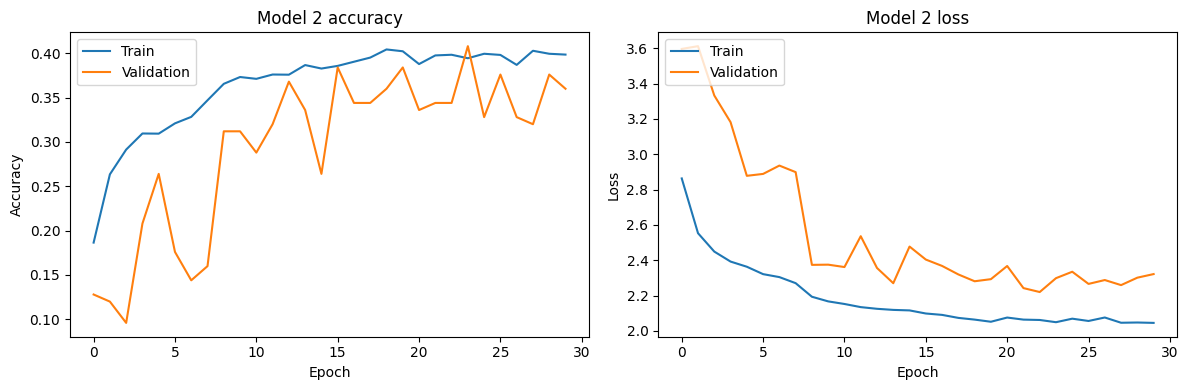

In [268]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Model 2 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('Model 2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

It looks like the validation data is fitting slightly better to the training accuracy and loss than the previous model. However, the training accuracy is lower and the loss is higher than the first model. 

In [269]:
# Predict on the test data.
predictions2 = model_2.predict(test_generator2)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


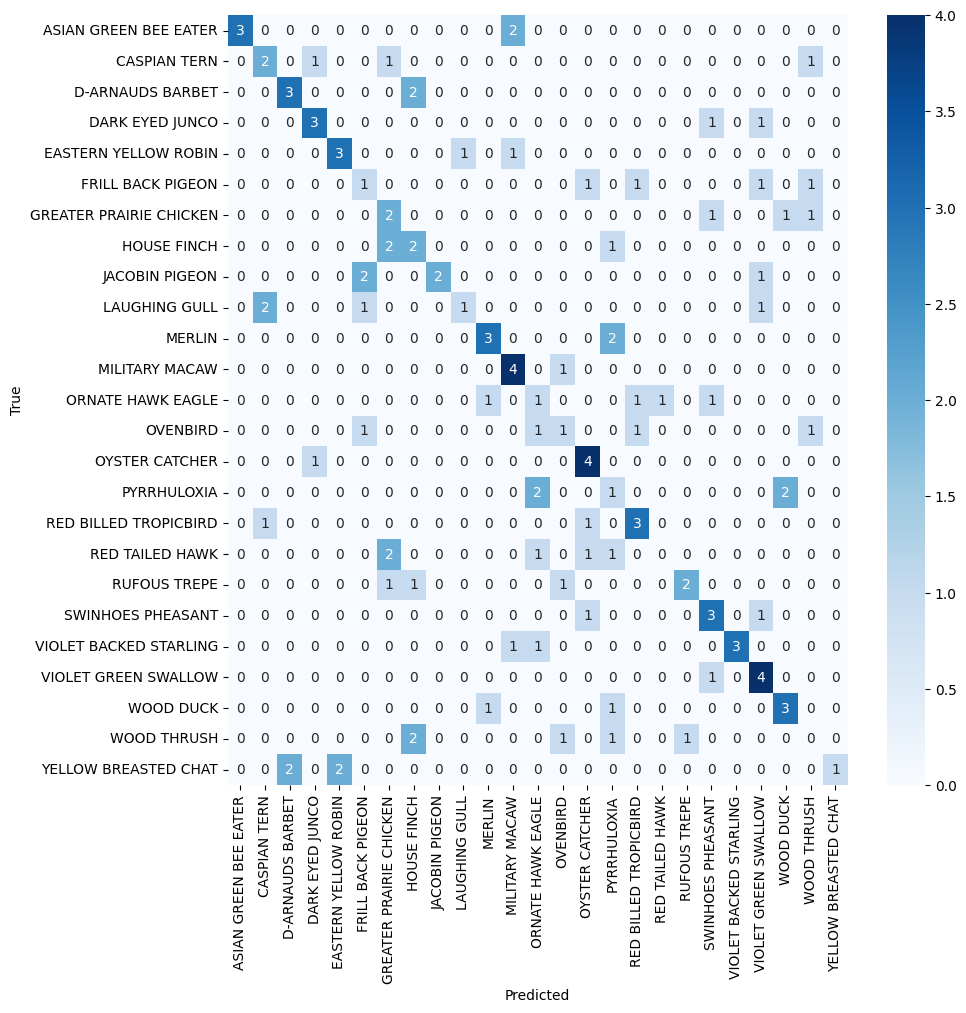

                         precision    recall  f1-score   support

  ASIAN GREEN BEE EATER       1.00      0.60      0.75         5
           CASPIAN TERN       0.40      0.40      0.40         5
       D-ARNAUDS BARBET       0.60      0.60      0.60         5
        DARK EYED JUNCO       0.60      0.60      0.60         5
   EASTERN YELLOW ROBIN       0.60      0.60      0.60         5
      FRILL BACK PIGEON       0.20      0.20      0.20         5
GREATER PRAIRIE CHICKEN       0.25      0.40      0.31         5
            HOUSE FINCH       0.29      0.40      0.33         5
         JACOBIN PIGEON       1.00      0.40      0.57         5
          LAUGHING GULL       0.50      0.20      0.29         5
                 MERLIN       0.60      0.60      0.60         5
         MILITARY MACAW       0.50      0.80      0.62         5
      ORNATE HAWK EAGLE       0.17      0.20      0.18         5
               OVENBIRD       0.25      0.20      0.22         5
         OYSTER CATCHER 

In [279]:
# Get the actual test labels.
true_labels2 = top_birds_test_df['labels'].values

# Get the indices of the max probabilities.
predicted_classes2 = np.argmax(predictions2, axis=1)

# Get a dictionary mapping indices to class names.
index_to_class2 = {v: k for k, v in train_generator2.class_indices.items()}

# Get the class names.
predicted_birds2 = [index_to_class2[i] for i in predicted_classes2]

# Get the unique class labels from the true and predicted labels.
class_labels2 = np.unique(np.concatenate((true_labels2, predicted_birds2)))

# Compute confusion matrix with those class labels. 
cm2 = confusion_matrix(true_labels2, predicted_birds2, labels=class_labels2)

# Plot the confusion matrix.
plt.figure(figsize=(10, 10))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels2, yticklabels=class_labels2)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot the precision, recall, and f1-score for all 25 birds and the overall accuracy. 
print(classification_report(top_birds_test_df.labels, predicted_birds2))

The first model has an accuracy of 44% and no birds have a perfect recall this itme. The weighted precision is 49%, recall is 44%, and f1-score is 43%. The weighted metrics for the first model are here: precision is 48%, recall is 44%, and f1-score is 42%. So the second model seems to do slightly better than the first model but it isn't a big increase. 

# Model 3 - Data augmentation and pre-trained model

This final model will use data augmentation again but also include a pre-trained model. 

EfficientNetV2B0 is a model where we can load pre-trained weights into our model. Since this pre-trained model has seen many kinds of images our prediction should improve. 

In [271]:
# Create data generators with data augmentation. 
train_datagen3 = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   shear_range=0.2,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

# Create data generators with no data augmentation. 
test_datagen3 = ImageDataGenerator()

# Create the training generator. 
train_generator3 = train_datagen3.flow_from_dataframe(
    top_birds_train_df,
    x_col= 'filepaths', 
    y_col= 'labels',
    target_size=(img_h, img_w), 
    batch_size=batch_size,
    class_mode='categorical',
    seed=12345,
    shuffle= True)

# Create the validation generator. 
val_generator3 = train_datagen3.flow_from_dataframe(
    top_birds_val_df,
    x_col= 'filepaths', 
    y_col= 'labels',
    target_size=(img_h, img_w), 
    batch_size=batch_size,
    class_mode='categorical',
    seed=12345,
    shuffle= True)

# Create the testing generator. 
test_generator3 = test_datagen3.flow_from_dataframe(
    top_birds_test_df,
    x_col= 'filepaths', 
    y_col= None,
    target_size=(img_h, img_w), 
    batch_size=batch_size,
    class_mode=None,
    seed=12345,
    shuffle= False)



Found 5340 validated image filenames belonging to 25 classes.
Found 125 validated image filenames belonging to 25 classes.
Found 125 validated image filenames.


In [272]:
# Load the pretained model.
pretrained_model = tf.keras.applications.EfficientNetV2B0(
    input_shape=(img_h, img_w, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Make sure that the pretrained model cannot be trainable. 
pretrained_model.trainable = False

In [273]:
# Define the third model. 
model_3 = Sequential([
    Input(shape=(img_h, img_w, 3)),
    pretrained_model,
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(25, activation='softmax')
])

# Get a summary of the model. 
model_3.summary()

# Compile the model. 
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'recall', 'f1_score', 'auc'])

Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)  │ (None, 1280)           │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_22 (Flatten)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_48          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 25)             │        12,825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,590,057 (25.14 MB)

 Trainable params: 669,721 (2.55 MB)

 Non-trainable params: 5,920,336 (22.58 MB)

There are 669,721 trainable parameters and almost 6 millioin non-trainable parameters.

In [274]:
# Define reduced learning and reduce learning rate. 
early_stopping = EarlyStopping(monitor='val_loss', patience=8, verbose=1)
reduce_learning = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1, min_lr=1e-6)

# Train the model.
history_3 = model_3.fit(
    train_generator3,
    validation_data=val_generator3, 
    epochs=30,
    verbose=1,
    callbacks=[reduce_learning, early_stopping])

Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


167/167 ━━━━━━━━━━━━━━━━━━━━ 26s 129ms/step - accuracy: 0.8042 - auc: 0.9695 - f1_score: 0.7991 - loss: 0.7307 - recall: 0.7442 - val_accuracy: 0.9200 - val_auc: 0.9993 - val_f1_score: 0.9217 - val_loss: 0.1857 - val_recall: 0.9200 - learning_rate: 0.0010
Epoch 2/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.9651 - auc: 0.9988 - f1_score: 0.9630 - loss: 0.1185 - recall: 0.9586 - val_accuracy: 0.9360 - val_auc: 0.9995 - val_f1_score: 0.9369 - val_loss: 0.1638 - val_recall: 0.9360 - learning_rate: 0.0010
Epoch 3/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 21s 123ms/step - accuracy: 0.9748 - auc: 0.9997 - f1_score: 0.9728 - loss: 0.0827 - recall: 0.9683 - val_accuracy: 0.9440 - val_auc: 0.9955 - val_f1_score: 0.9435 - val_loss: 0.1762 - val_recall: 0.9360 - learning_rate: 0.0010
Epoch 4/30
167/167 ━━━━━━━━━━━━━━━━━━━━ 21s 122ms/step - accuracy: 0.9748 - auc: 0.9995 - f1_score: 0.9717 - loss: 0.0814 - recall: 0.9704 - val_accuracy: 0.9600 - val_auc: 0.9998 - val_f1_score: 0.9589 - val_l

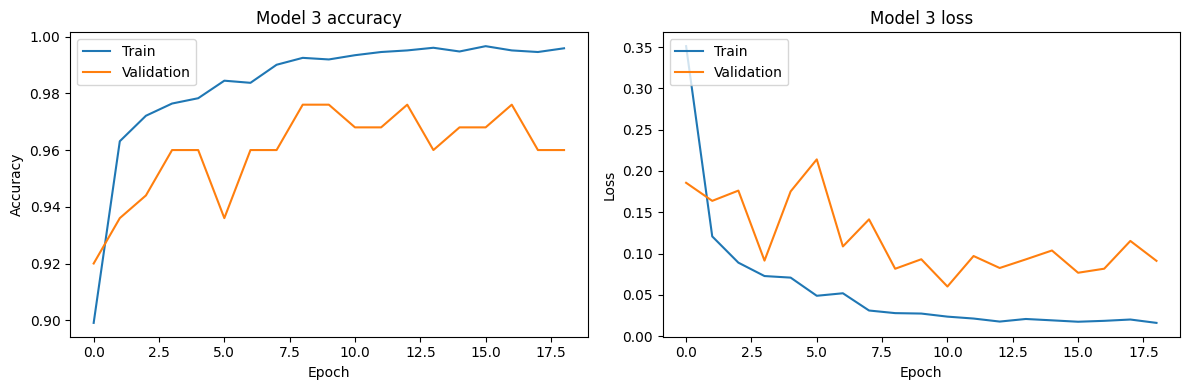

In [275]:
# Plot training & validation accuracy values.
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model 3 accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values.
plt.subplot(1, 2, 2)
plt.plot(history_3.history['loss'])
plt.plot(history_3.history['val_loss'])
plt.title('Model 3 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

The model seems to converge in an epoch or 2 based on the crossing of the validation and training loss metrics. The accuracy for both validation and training is above 90% and the loss is below 0.4. 

In [276]:
# Predict on the test data.
predictions3 = model_3.predict(test_generator3)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 371ms/step


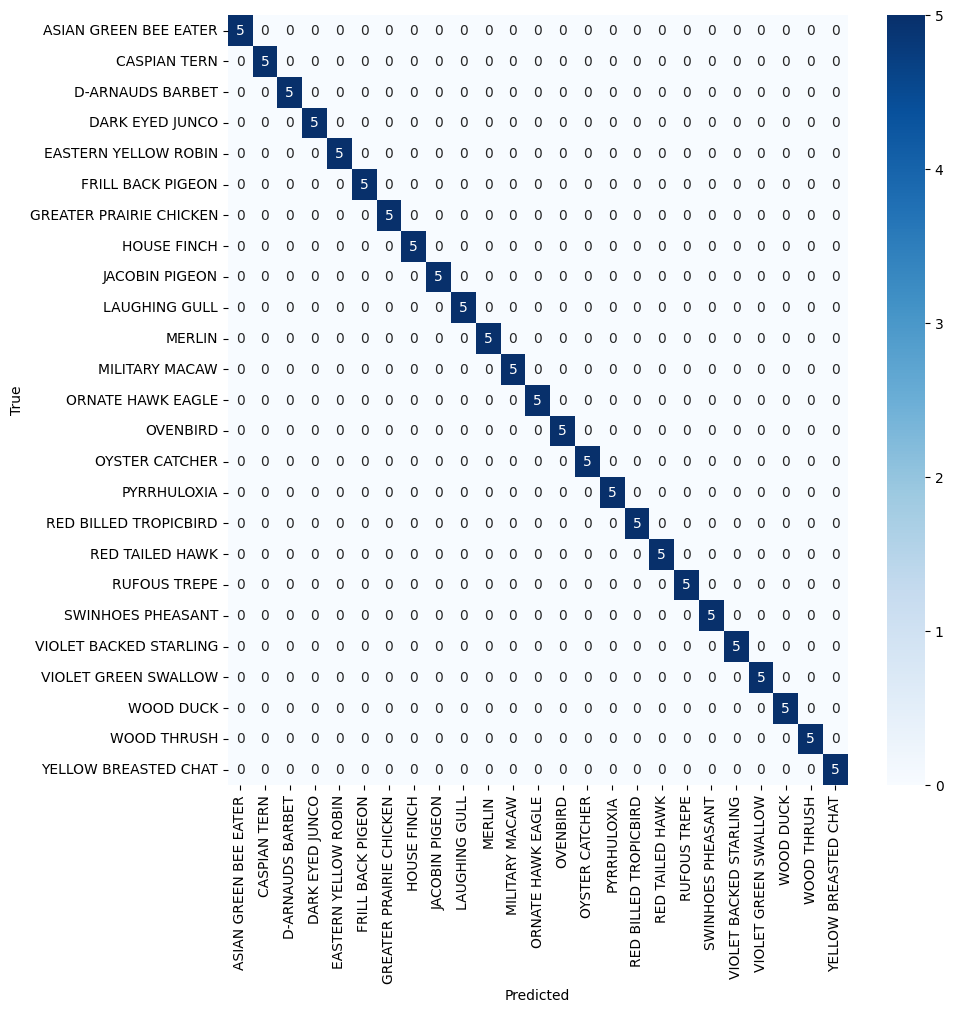

                         precision    recall  f1-score   support

  ASIAN GREEN BEE EATER       1.00      1.00      1.00         5
           CASPIAN TERN       1.00      1.00      1.00         5
       D-ARNAUDS BARBET       1.00      1.00      1.00         5
        DARK EYED JUNCO       1.00      1.00      1.00         5
   EASTERN YELLOW ROBIN       1.00      1.00      1.00         5
      FRILL BACK PIGEON       1.00      1.00      1.00         5
GREATER PRAIRIE CHICKEN       1.00      1.00      1.00         5
            HOUSE FINCH       1.00      1.00      1.00         5
         JACOBIN PIGEON       1.00      1.00      1.00         5
          LAUGHING GULL       1.00      1.00      1.00         5
                 MERLIN       1.00      1.00      1.00         5
         MILITARY MACAW       1.00      1.00      1.00         5
      ORNATE HAWK EAGLE       1.00      1.00      1.00         5
               OVENBIRD       1.00      1.00      1.00         5
         OYSTER CATCHER 

In [278]:
# Get the actual test labels.
true_labels3 = top_birds_test_df['labels'].values

# Get the indices of the max probabilities.
predicted_classes3 = np.argmax(predictions3, axis=1)

# Get a dictionary mapping indices to class names.
index_to_class3 = {v: k for k, v in train_generator3.class_indices.items()}

# Get the class names.
predicted_birds3 = [index_to_class3[i] for i in predicted_classes3]

# Get the unique class labels from the true and predicted labels.
class_labels3 = np.unique(np.concatenate((true_labels3, predicted_birds3)))

# Compute confusion matrix with those class labels. 
cm3 = confusion_matrix(true_labels3, predicted_birds3, labels=class_labels3)

# Plot the confusion matrix.
plt.figure(figsize=(10, 10))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels3, yticklabels=class_labels3)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot the precision, recall, and f1-score for all 25 birds and the overall accuracy. 
print(classification_report(top_birds_test_df.labels, predicted_birds3))

For the third model, all birds where perfectly predicted. The accuracy and weighted scores were all 100%. 

# Conclusion

| Model | Accuracy | Precision | Recall | F1-Score |
|-------|----------|-----------|--------|----------|
| Model 1 (without augmentation) | 44% | 48% | 44% | 42% |
| Model 2 (with augmentation) | 44% | 49% | 44% | 43% |
| Model 3 (pre-trained model) | 100% | 100% | 100% | 100% |


The third model did the best out of all of the models tested. The third model converged in an epoch or 2 when looking at the loss metric graph. Also, the third model had 100% accuracy, precision, recall, and f1-score for all birds. This is much different than the first two models. The first model had an accuracy of 44%, a weighted precision of 48%, recall of 44%, and f1-score of 42%. The second model which introduced data augmentation did slightly better with an accuracy of 44%, a weighted precision of 49%, recall of 44%, and f1-score of 43%. 

I expected a similar result to what happened but I did expect the second model with data augmentation to have better performance than it did. I also did not expect the third model with the pre-trained model included to have perfect prediction. 

Some additional things to try would be to include more kinds of data augmentation. This would allow the model to learn the pictures in even more ways and could increase predction. Additionally, if time and resources persisted, we could try to classify more birds. This kaggle dataset has 525 birds in it, so we could try to train with more images and see the prediction metrics. We could also change our neural network architecture to include more normalization, dropouts, or layers. This could increase performance of the first two models and slow the convergence on the third model. Finally, we could try training with different pre-trained models but since we got perfect prediction, we might not need to do this. 

# References

Tensorflow and Keras:

https://www.tensorflow.org/api_docs/python/tf/keras

https://www.tensorflow.org/api_docs/python/tf/keras/applications/EfficientNetV2B0

https://keras.io/guides/transfer_learning/

https://keras.io/api/applications/#usage-examples-for-image-classification-models

Kaggle:

https://www.kaggle.com/code/vencerlanz09/bird-classification-using-cnn-efficientnetb0

https://www.kaggle.com/code/hadeerismail/100bird-types-classification-efficientnet-acc-99


